In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import json

from modules.interfaces import User, DataBase
from modules.managers import PretradeDataManager, OrderManager, PortfolioManager
from modules.portfolio import *
from modules.tools import *

In [3]:
ac_info = read_json("config/mt5_account.json")["ftmo-demo"]
pre_db_info = read_json("config/postgres_info.json")["pre-trade"]
post_db_info = read_json("config/postgres_info.json")["post-trade"]
params = read_json("config/parameters.json")
asset_allocation = read_json("config/asset_allocation.json")

In [4]:
user = User().login_by_dict(ac_info)
pre_db = DataBase().connect_by_dict(pre_db_info)
post_db = DataBase().connect_by_dict(post_db_info)

Logged in as 1520198341 (FTMO-Demo2)
Connected to pre-trade (localhost:5432)
Connected to post-trade (localhost:5432)


In [5]:
pdm = PretradeDataManager(user, pre_db)
om = OrderManager(user, post_db)
pm = PortfolioManager(om, pdm, asset_allocation, params)

In [6]:
universe = pdm.get_universe()

In [7]:
symbols = ["EURUSD"]

print(symbols)


results = pd.Series()

fixed_cost = 0  # .00001
commission = 0.00003
slippage = 0  # .00001


all_bars = {
    symbol: pdm.get_bars(symbol).drop(columns=["id", "symbol"]) for symbol in symbols
}

pnl_df = pd.DataFrame()
pnl_net_df = pd.DataFrame()

train_size = 10000
step_size = 6000

symbol = symbols[0]
print("=========================================================")
print(symbol)

bars = all_bars[symbol]
point = universe.loc[universe.symbol == symbol, "point"].values[0]
spread = bars.spread * point

# params_FilteredBollingerBand = params[symbol]["filtered_bollinger_band"]["params"]
params_FilteredBollingerBand = [
    {
        "ema_lookback": n,
        "vol_lookback": 48,
        "avg_vol_lookback": 6000,
        "width": 1,
        "ema_filter_lookback": n * 8,
    }
    for n in range(30, 91, 3)
]

['EURUSD']


C:\Users\benka\AppData\Local\Temp\ipykernel_1632\3885078182.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  results = pd.Series()


EURUSD


In [8]:
from modules.trading_models_test.rule_based_models import FilteredBollingerBand

weighted_bet_df = pd.DataFrame()
for params in params_FilteredBollingerBand:
    model = FilteredBollingerBand(1, params=params, bars=bars)
    weighted_bet_df[f'{params["ema_lookback"]}_{params["width"]}'] = model.walkforward(
        train_size=train_size,
        step_size=step_size,
        max_lookback=max(params.values()),
    ).weighted_bet

In [9]:
fixed_cost = 0  # .00001
commission = 0.00003
slippage = 0  # .00001

In [10]:
pos = weighted_bet_df.fillna(0).mean(axis=1)

In [11]:
from modules.trading_models_test.indicators import TechnicalIndicator

signal = pd.Series(1.0, index=pos.index)
cost = (spread + commission) * pos.abs()
price = bars.close
vol = price * TechnicalIndicator(close=bars.close).get_combvol(48, 6000)
tp = 2 * vol
sl = 3 * vol
period = 12

In [12]:
label = label_tribar(signal,price,tp,sl,period)
pnl = backtest(signal,price,tp,sl,period)
label.loc[label==-1.0] = 0.0
label.name = 'label'
label.value_counts()

1.0    30863
0.0    27380
Name: label, dtype: int64

In [34]:
from ta import add_all_ta_features

feat_ = add_all_ta_features(
    bars.drop(columns="real_volume"),
    open="open",
    high="high",
    low="low",
    close="close",
    volume="tick_volume",
    fillna=True,
)

In [47]:
feat = feat_
feat = feat_.diff(12) / feat_.diff(12).rolling(480).std()
#feat = (feat_ - feat_.rolling(12).mean()) / feat_.rolling(480).std()
#feat = feat.clip(lower=feat.quantile(0.05),upper=feat.quantile(0.95),axis=1)

feat = feat.dropna()

In [48]:
from sklearn.decomposition import PCA

n_components=30
model = PCA(n_components=n_components)
feat = pd.DataFrame(model.fit_transform(feat),index=feat.index,columns=[f'PC{n}' for n in range(n_components)])

hist_pnl = signal.shift(1) * np.log(price).diff()
feat["rolling_sr"] = hist_pnl.rolling(480).mean() / hist_pnl.rolling(480).std()

feat.dropna(inplace=True)

In [49]:
meta_df = pd.concat([label, feat], axis=1).dropna()

train_set, test_set = (
    meta_df.iloc[: len(meta_df) // 2],
    meta_df.iloc[len(meta_df) // 2:],
)

from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

train_y, train_x = train_set.label, train_set.drop(columns="label")

test_y, test_x = test_set.label, test_set.drop(columns="label")

print(len(train_set))
print(len(test_set))

27735
27736


In [50]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier


#model = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=300300)
model = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=300300)
#model = LogisticRegressionCV(fit_intercept=False, cv=5, penalty="l2",max_iter=500)

model.fit(y=train_y, X=train_x)

print(model.score(y=train_y, X=train_x))

print(model.score(y=test_y, X=test_x))

0.5427798810167658
0.5327732910297087


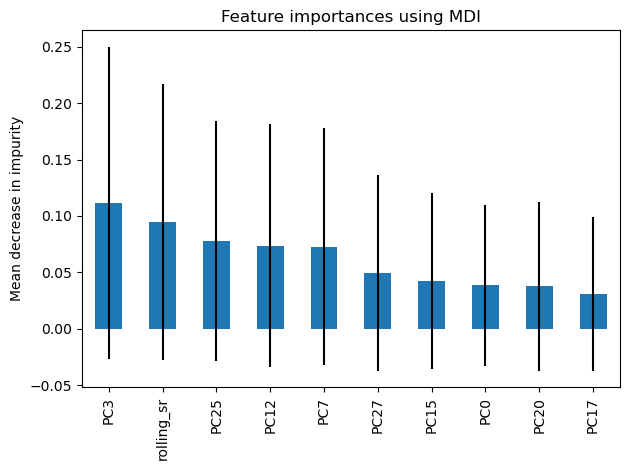

In [51]:
feature_names = train_x.columns
importances = model.feature_importances_

std =  pd.Series(np.std([tree.feature_importances_ for tree in model.estimators_], axis=0), index=feature_names)
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

top_feat = forest_importances.head(10).index

fig, ax = plt.subplots()
forest_importances[top_feat].plot.bar(yerr=std[top_feat], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [52]:
prob = model.predict_proba(X=test_x).max(axis=1)
pred = model.predict(X=test_x)

from scipy.stats import norm

size = pd.Series(pred * norm.cdf(prob), index=test_x.index)
# size = pd.Series(pred, index=test_x.index).clip(lower=0)

In [56]:
meta_pnl = backtest(signal * size, price, tp, sl, period)

<Axes: >

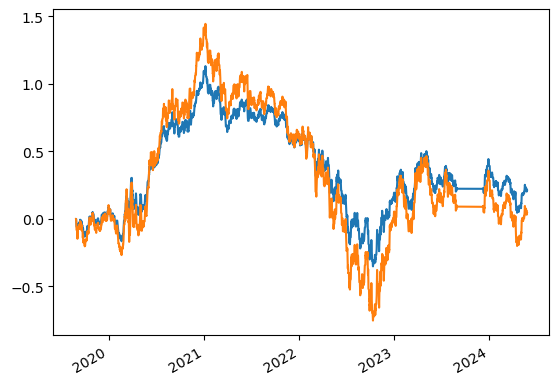

In [57]:
meta_pnl.loc[test_set.index].fillna(0).rolling(12).mean().cumsum().plot()
pnl.loc[test_set.index].fillna(0).rolling(12).mean().cumsum().plot()

NameError: name 'top_feat' is not defined

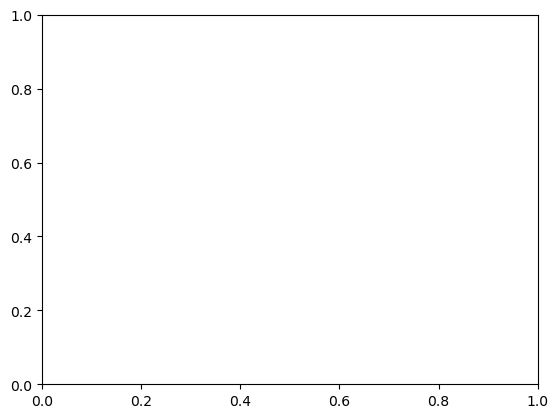

In [22]:
from sklearn.inspection import permutation_importance

feature_names = train_x.columns
result = permutation_importance(
    model, test_x, test_y, n_repeats=10, random_state=42, n_jobs=2
)

std = pd.Series(result.importances_std, index=feature_names)
forest_importances = pd.Series(
    result.importances_mean, index=feature_names
).sort_values(ascending=False)

#top_feat = forest_importances.index

fig, ax = plt.subplots()
forest_importances[top_feat].plot.bar(yerr=std[top_feat], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()